In [20]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam

In [12]:
plt.ion()
plt.show()

In [4]:
basedir = 'data/dogs/'
files = [f for f in listdir(basedir) if isfile(join(basedir, f))]
len(files)

10222

In [3]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def resizeImg(Xg):
#     cv.normalize(Xg,  Xg, 0, 1, cv.NORM_MINMAX)
#     Xg/=255.0
    Xg = normalize(Xg)
    if Xg.shape[0] >= 224:
        return cv.resize(Xg,(224,224), cv.INTER_AREA)
    else:
        return cv.resize(Xg,(224,224), cv.INTER_CUBIC)

    
def readAndResize(filename):
    dog = misc.imread(basedir + filename)
    return resizeImg(dog)

In [5]:
dog = readAndResize(files[0])
print(dog.shape)
plt.imshow(dog)
# readAndResize(files[0])

(224, 224, 3)


(375, 500, 3)


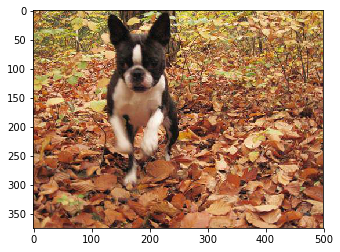

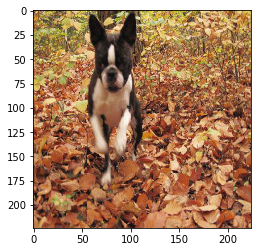

In [18]:
dog = misc.imread(basedir + files[0])
print(dog.shape)
plt.imshow(dog)
plt.show()
plt.imshow(resizeImg(dog))
plt.show()

In [45]:
def getInputImages(ids):
    data = [readAndResize(i) for i in  ids]
    data = np.stack(data)
    return data

In [ ]:
# gan.predict()28, 28, 64)   

In [72]:
ii = Input(shape=(224,224,3))
 
    
# x = Dense(100, activation='relu')(ii)
# x = Dropout(0.6)(x)
# x = Dense(50, activation='relu')(c)

x = Convolution2D(16, (3, 3), activation='relu', padding='same', input_shape=(224,224,3))(ii)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

x = Convolution2D(32, (3, 3),  activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
# x = Dropout(0.6)(x)

x = Convolution2D(64, (3, 3),  activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
# x = Dropout(0.6)(x)

middle = Flatten()(x)
x = Reshape((28, 28, 64) )(middle)
x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2)) (x)

x = Convolution2D(32, (3, 3),  activation='relu', padding='same')(x)
x = UpSampling2D((2,2)) (x)
# x = Dropout(0.6)(x)

x = Convolution2D(3, (3, 3),  activation='relu', padding='same')(x)
x = UpSampling2D((2,2)) (x)
# x = Dropout(0.6)(x)


model = Model(ii, x)
# gan = Model(middle, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 28, 28, 64)        0         
__________

In [38]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
#     def on_train_begin(self, logs={}):

        
    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        if self.i% 1 != 0:
            return
        
        
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)
        
        random_img_id = random.randint(0,len(files))
        output = model.predict(getInputImages([files[random_img_id]]))
        print(output.shape)
        plt.subplot(1,3,2)
        plt.imshow(output[0])
        plt.subplot(1,3,3)
        plt.imshow(readAndResize(files[random_img_id]))
        plt.show()
        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

(1, 224, 224, 3)


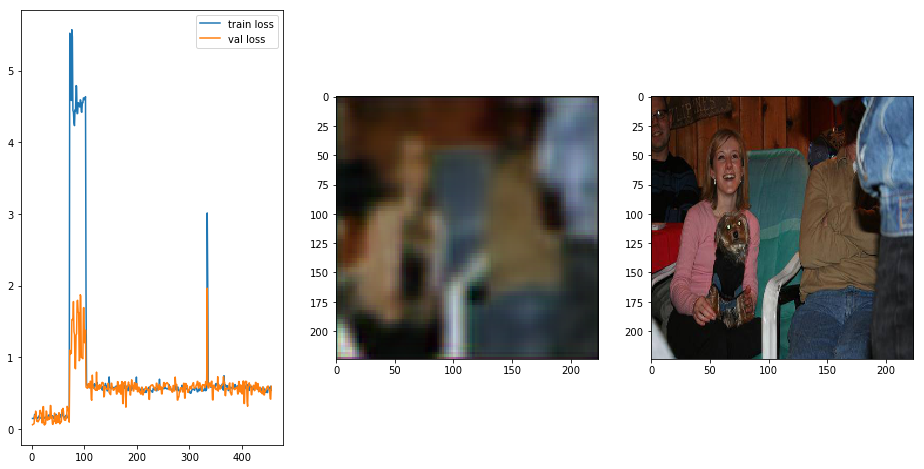

9/9 [==============================] - 2s - loss: 0.5401 - acc: 0.0029 - val_loss: 0.5958 - val_acc: 6.6433e-04
Epoch 2/2
6/9 [===================>..........] - ETA: 1s - loss: 0.5027 - acc: 0.004 - ETA: 0s - loss: 0.5430 - acc: 0.0024

KeyboardInterrupt: 

In [73]:
step = 10
epochs = 2
batch_size = 3

# redlr = keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=20)

for i in range(0, len(files), step):
    x_train = getInputImages(files[i:(i + step)])

    model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[myPlot],
              validation_split = 0.1)

## Model 1

In [22]:
input_img = Input(shape=(224,224,3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, decoded)
model.compile(optimizer='adadelta', loss='binary_crossentropy')
 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 112, 112, 32)      0         
__________

## Model 2


In [40]:
from autoencoder_layers import DependentDense
from keras import models

In [25]:
keras.__version__


'2.0.6'

In [105]:

input_img = Input(shape=(224,224,3))

# x = Conv2D(32, (3, 3), activation='tanh', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Dropout(0.25)(x)

# x = Flatten()(x)
# x = Dense(30, activation='tanh')(x)

# x = Dense(32 * 14 * 14)(x)
# x = Reshape((32, 14, 14) )(x)

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)


# x = UpSampling2D((2,2)) (x)
# x = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

x = Convolution2D(16, (3, 3), activation='tanh', padding='same', input_shape=(224,224,3))(input_img)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

x = Convolution2D(32, (3, 3),  activation='tanh', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)


# x = Dropout(0.6)(x)

x = Convolution2D(64, (3, 3),  activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)


# x = Flatten()(x)
# x = Dense(28 * 28 * 32)(x)
# x = Reshape((28, 28, 32 ))(x)

# x = Dense(8 * 8 * 2)(x)
# x = Reshape((8, 8, 2 ))(x)




# x = Reshape((28, 28, 64) )(x)
# x = Dense(30, activation='tanh')(x)
# x = Reshape((56, 56, 32) )(x)


x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2)) (x)

x = Convolution2D(32, (3, 3),  activation='tanh', padding='same')(x)
x = UpSampling2D((2,2)) (x)


x = Convolution2D(3, (3, 3),  activation='tanh', padding='same')(x)
x = UpSampling2D((2,2)) (x)


model = Model(input_img, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy')
 

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 28, 28, 64)        0         
__________

In [111]:
from keras.layers import *

In [112]:

input_img = Input(shape=(224,224,3))


x = Convolution2D(16, (3, 3), activation='relu', padding='same', input_shape=(224,224,3))(input_img)
x1 = x
x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
# x = x + x1
x = merge([x, x1], mode='sum')
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

x = Convolution2D(32, (3, 3),  activation='tanh', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)


# x = Dropout(0.6)(x)

x = Convolution2D(64, (3, 3),  activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same') (x)



x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2)) (x)

x = Convolution2D(32, (3, 3),  activation='tanh', padding='same')(x)
x = UpSampling2D((2,2)) (x)


x = Convolution2D(3, (3, 3),  activation='tanh', padding='same')(x)
x = UpSampling2D((2,2)) (x)


model = Model(input_img, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy')
 

model.summary()
myPlot.initVars()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_67 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_230 (Conv2D)              (None, 224, 224, 16)  448         input_67[0][0]                   
____________________________________________________________________________________________________
conv2d_231 (Conv2D)              (None, 224, 224, 16)  2320        conv2d_230[0][0]                 
____________________________________________________________________________________________________
merge_1 (Merge)                  (None, 224, 224, 16)  0           conv2d_231[0][0]                 
                                                                   conv2d_230[0][0]        

In [113]:
step = 10
epochs = 2
batch_size = 3

# redlr = keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=20)

for i in range(0, len(files), step):
    x_train = getInputImages(files[i:(i + step)])

    model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[myPlot],
              validation_split = 0.1)

(1, 224, 224, 3)


KeyboardInterrupt: 

## GAN

In [28]:
img_rows = 224
img_cols = 224
channels = 3
img_shape = (img_rows, img_cols, channels)


def build_generator():

    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)
    return Model(noise, img)


In [126]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    
    x = Convolution2D(16, (3, 3), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)

    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

    x = Convolution2D(32, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

    x = Convolution2D(16, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

    x = Flatten(input_shape=img_shape)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, x)

    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 56, 56, 16)        4624      
__________

In [82]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [125]:
discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 56, 16)        4624      
__________

In [30]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              525312    
__________

In [32]:
z = Input(shape=(100,))
img = generator(z)

In [132]:
discriminator.trainable = False
valid = discriminator(img)

In [133]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [134]:
epochs = 100
batch_size = 10
save_interval= 10
half_batch = int(batch_size / 2)

## Test discriminator

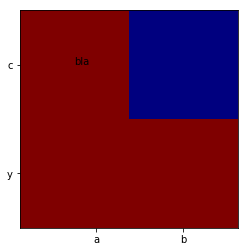

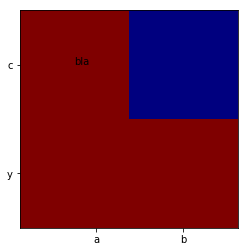

1

In [105]:
fig = plt.figure()
ax = plt.subplot(111)
plt.imshow([[1,0],[1,1]], interpolation = 'nearest', cmap = 'jet')
plt.xticks([0.2, 1], ['a', 'b'])
plt.yticks([0, 1], ['c', 'y'])
ax.annotate('bla', [0,0])
plt.show()
1

In [120]:
def getData(size):
    idx = list(np.random.randint(0, len(files), size))
    imgs = getInputImages([files[i] for i in idx])
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)
    d_output = np.append(np.ones((size, 1)), np.zeros((size, 1)), axis=0)
    return d_input, d_output
    

In [130]:
discriminator.trainable = True
for epoch in range(epochs):

    d_input, d_output = getData(half_batch)

    discriminator.fit(d_input, d_output, epochs = 3)
    
    t_input, t_output = getData(2)
    pred = (discriminator.predict(t_input) > 0.5).astype(int)
    print('pred ', pred,  'true ', t_output)


Epoch 1/3
10/10 [==============================] - 1s - loss: 0.2123 - acc: 0.9000
Epoch 2/3
10/10 [==============================] - 1s - loss: 0.0562 - acc: 1.0000
Epoch 3/3
10/10 [==============================] - 1s - loss: 0.0086 - acc: 1.0000
pred  [[1]
 [1]
 [0]
 [0]] true  [[ 1.]
 [ 1.]
 [ 0.]
 [ 0.]]
Epoch 1/3
10/10 [==============================] - 1s - loss: 0.0039 - acc: 1.0000
Epoch 2/3
10/10 [==============================] - 1s - loss: 0.0028 - acc: 1.0000
Epoch 3/3
10/10 [==============================] - 1s - loss: 0.0023 - acc: 1.0000
pred  [[1]
 [1]
 [0]
 [0]] true  [[ 1.]
 [ 1.]
 [ 0.]
 [ 0.]]
Epoch 1/3
10/10 [==============================] - 1s - loss: 2.1510e-04 - acc: 1.0000
Epoch 2/3
10/10 [==============================] - 1s - loss: 2.0419e-04 - acc: 1.0000
Epoch 3/3


KeyboardInterrupt: 

g_loss :  9.00887


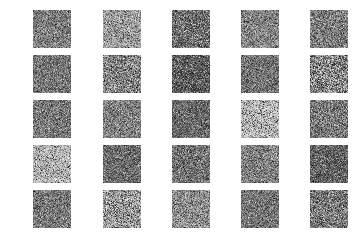

g_loss :  9.30175
g_loss :  8.95535
g_loss :  8.03847
g_loss :  7.95127
g_loss :  9.91292
g_loss :  10.4931
g_loss :  10.4806
g_loss :  10.4567
g_loss :  9.92506
g_loss :  9.93851


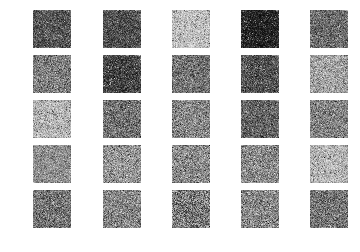

g_loss :  8.64664
g_loss :  8.40705
g_loss :  8.44404
g_loss :  8.07994
g_loss :  7.36853
g_loss :  6.89503
g_loss :  8.0994
g_loss :  8.44873
g_loss :  4.96657
g_loss :  4.86835


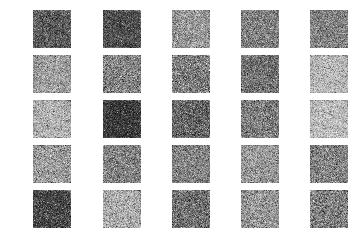

g_loss :  4.52107
g_loss :  5.86407
g_loss :  4.0922
g_loss :  3.04931
g_loss :  4.11216
g_loss :  4.91922
g_loss :  4.96639
g_loss :  4.10551
g_loss :  3.78099
g_loss :  4.00275


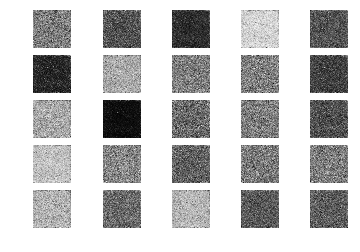

g_loss :  4.72156
g_loss :  4.97171
g_loss :  4.64004
g_loss :  4.55765
g_loss :  5.05738


KeyboardInterrupt: 

In [136]:
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


for epoch in range(epochs):
    d_input, d_output = getData(half_batch)

    discriminator.trainable = True
    discriminator.train_on_batch(d_input, d_output)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    print('g_loss : ', g_loss)

    # Plot the progress
#     print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    if epoch % save_interval == 0:
        save_imgs(epoch)

In [ ]:
nb_filters = 32
nb_pool=2
nb_conv=3

model = models.Sequential()
d = Dense(30)
c = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', input_shape=(1, 28, 28))
mp =MaxPooling2D((nb_pool, nb_pool), border_mode='same')
# =========      ENCODER     ========================
model.add(c)
model.add(Activation('tanh'))
model.add(mp)
model.add(Dropout(0.25))
# =========      BOTTLENECK     ======================
model.add(Flatten())
model.add(d)
model.add(Activation('tanh'))
# =========      BOTTLENECK^-1   =====================
model.add(DependentDense(nb_filters * 14 * 14, d))
model.add(Activation('tanh'))
model.add(Reshape((nb_filters, 14, 14)))
# =========      DECODER     =========================
model.add(DePool2D(mp, size=(nb_pool, nb_pool)))
model.add(Deconvolution2D(c, border_mode='same'))
model.add(Activation('tanh'))


# input_img = Input(shape=(224,224,3))

# x = Conv2D(32, (3, 3), activation='tanh', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Dropout(0.25)(x)

# x = Flatten()(x)
# x = Dense(30, activation='tanh')(x)

# x = DependentDense(32 * 14 * 14, x)
# x = Reshape((32, 14, 14) )(x)

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)


# x = DePool2D(MaxPooling2D((2, 2), padding='same')(x), size = (2,2))
# x = Deconvolution2D(Conv2D(32, (3, 3), activation='tanh', padding='same')(x))


# model = Model(input_img, decoded)
model.compile(optimizer='adadelta', loss='binary_crossentropy')
 

model.summary()